# Context-Aware Model 1

### Install and Import libraries

In [ ]:
!pip install tensorflow
!pip install opencv-python
!pip install matplotlib

In [ ]:
import tensorflow as tf
import numpy as np
import json
from matplotlib import pyplot as plt
import os
import cv2

### Load Images and Labels Dataset

In [ ]:
# helper function to load images 
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
# helper function to load labels
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return label['class'], label['bbox'], label['scene']

In [ ]:
# load images and labels from local machine 
train_images = tf.data.Dataset.list_files("/content/augdata/train/images/*.jpg", shuffle=False)
val_images = tf.data.Dataset.list_files("/content/augdata/val/images/*.jpg", shuffle=False)
test_images = tf.data.Dataset.list_files("/content/augdata/test/images/*.jpg", shuffle=False)

train_labels = tf.data.Dataset.list_files("/content/augdata/train/labels/*.json", shuffle=False)
test_labels = tf.data.Dataset.list_files("/content/augdata/test/labels/*.json", shuffle=False)
val_labels = tf.data.Dataset.list_files("/content/augdata/val/labels/*.json", shuffle=False)

# preprocess images and labels 
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (150,150)))
train_images = train_images.map(lambda x: x/255)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint64, tf.float16, tf.uint64]))

test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (150,150)))
test_images = test_images.map(lambda x: x/255)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint64, tf.float16, tf.uint64]))

val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (150,150)))
val_images = val_images.map(lambda x: x/255)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint64, tf.float16, tf.uint64]))

In [ ]:
# combine images and lables into one Dataset object
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(2000)
train = train.batch(32)

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1000)
test = test.batch(704) # test batch uses one batch to prevent using batch averages for testing results

val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(32)

### Build and Train the model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model

In [ ]:
# build model architecture using Functional API
def build_model(): 
    input_layer = Input(shape=(150,150,3))
    vgg = VGG16(include_top=False)(input_layer)

    # Object Classification branch  
    b1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(b1)
    class2 = Dense(8, activation='softmax')(class1)
    
    # Bounding box branch
    b2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(b2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    # Scene Classification branch
    b3 = GlobalMaxPooling2D()(vgg)
    sclass1 = Dense(2048, activation='relu')(b3)
    sclass2 = Dense(4, activation='softmax')(sclass1)
    
    CAobjectdetection1 = Model(inputs=input_layer, outputs=[class2, regress2, sclass2])
    return CAobjectdetection1

In [ ]:
CAobjectdetection1 = build_model()

In [ ]:
# helper function to calculate the running mean IoU of each training batch
def mean():
    count = 0
    mean = 0
    
    def inner(value):
        nonlocal count, mean
        count += 1
        mean += (value - mean) / count
        return mean
    
    return inner

In [ ]:
# custom function to calculate bounding box IoU metric
def iou(y_true, y_pred):
    AoG = tf.abs(tf.transpose(y_true)[2] - tf.transpose(y_true)[0] + 1) * tf.abs(tf.transpose(y_true)[3] - tf.transpose(y_true)[1] + 1)
    AoP = tf.abs(tf.transpose(y_pred)[2] - tf.transpose(y_pred)[0] + 1) * tf.abs(tf.transpose(y_pred)[3] - tf.transpose(y_pred)[1] + 1)

    overlap_0 = tf.maximum(tf.transpose(y_true)[0], tf.transpose(y_pred)[0])
    overlap_1 = tf.maximum(tf.transpose(y_true)[1], tf.transpose(y_pred)[1])
    overlap_2 = tf.minimum(tf.transpose(y_true)[2], tf.transpose(y_pred)[2])
    overlap_3 = tf.minimum(tf.transpose(y_true)[3], tf.transpose(y_pred)[3])

    intersection = (overlap_2 - overlap_0 + 1) * (overlap_3 - overlap_1 + 1)
    union = AoG + AoP - intersection
    iou = intersection / union
    iou = tf.clip_by_value(iou, 0.0 + tf.keras.backend.epsilon(), 1.0 - tf.keras.backend.epsilon())

    return iou 

In [ ]:
# learning rate decays by 75% of prev rate per epoch to prevent overfitting
lr_decay = (1./0.75 -1)/len(train)

In [ ]:
# low learning rate since transfer learning is used
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [ ]:
# Subclassed Keras Model() class
class CAOD1(Model): 
    # initialized with custom metrics to calculate object and scene prediction accuracy, and bbox IoU
    def __init__(self, odmodel,  **kwargs): 
        super().__init__(**kwargs)
        self.model = odmodel
        self.acc_metric = tf.keras.metrics.Accuracy(name="acc")
        self.scene_acc_metric = tf.keras.metrics.Accuracy(name="scene_acc")
        self.iou = iou
        
    # compiled with customized loss functions
    def compile(self, opt, classloss, localizationloss, sceneclassloss, **kwargs):
        super().compile(**kwargs)
        self.opt = opt
        self.closs = classloss
        self.lloss = localizationloss
        self.sloss = sceneclassloss
        
    # model training 
    def train_step(self, batch, **kwargs): 

        # take one batch
        X, y = batch                                                                                
        iou_result = 0.0
        
        with tf.GradientTape() as tape: 

            # make predictions 
            classes, coords, scenes = self.model(X, training=True)
            
            # calculate losses
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            batch_sceneloss = self.sloss(y[2], scenes)

            total_loss = batch_localizationloss + 0.5*batch_sceneloss + 0.5*batch_classloss
            grad = tape.gradient(total_loss, self.model.trainable_variables)
            
        # apply gradients
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        # update metrics
        self.acc_metric.update_state(tf.argmax(y[0], 1), tf.argmax(classes, 1))
        self.scene_acc_metric.update_state(tf.argmax(y[2], 1), tf.argmax(scenes, 1))
        iou_result = iou(tf.cast(y[1], tf.float32), coords)
        mean_iou = mean()
        
        # show training progress
        return {"total loss":total_loss, "accuracy":self.acc_metric.result(), "mean iou":mean_iou(iou_result), 
                "scene accuracy":self.scene_acc_metric.result()}
    
    # used for validation and test sets
    def test_step(self, batch, **kwargs): 

        # take one batch
        X, y = batch
        iou_result=0.0
        
        #make predictions
        classes, coords, scenes = self.model(X, training=False)
        
        # calculate losses
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        batch_sceneloss = self.sloss(y[2], scenes)
        total_loss = batch_localizationloss + 0.5*batch_sceneloss + 0.5*batch_classloss
        
        # update metrics
        self.acc_metric.update_state(tf.argmax(y[0], 1), tf.argmax(classes, 1))
        self.scene_acc_metric.update_state(tf.argmax(y[2], 1), tf.argmax(scenes, 1))
        iou_result = iou(tf.cast(y[1], tf.float32), coords)
        mean_iou = mean()
        
        # return results
        return {"total loss":total_loss, "accuracy":self.acc_metric.result(), "mean iou":mean_iou(iou_result), 
                "scene accuracy":self.scene_acc_metric.result()}
    
    # reinitialize metrics after each epoch
    @property
    def metrics(self):
        return [self.acc_metric, self.scene_acc_metric] 
        
    # used to make predictions
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [ ]:
model = CAOD1(CAobjectdetection1)

In [ ]:
model.compile(opt, 
              tf.keras.losses.CategoricalCrossentropy(), 
              tf.keras.losses.Huber(),
              tf.keras.losses.CategoricalCrossentropy())

In [ ]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=4)

In [ ]:
hist = model.fit(train, epochs=30, validation_data=val, callbacks=[early_stop])

In [ ]:
# helper method to plot graph for mean IoU
histmeannparray = np.array(hist.history['mean iou'])
histvalmeannparray = np.array(hist.history['val_mean iou'])
meanlist = []
valmeanlist = []

for x in range(0,24):
    arr1 = histmeannparray[x]
    arr2 = histvalmeannparray[x]
    means = np.mean(arr1)
    valmeans = np.mean(arr2)
    meanlist.append(means)
    valmeanlist.append(valmeans)

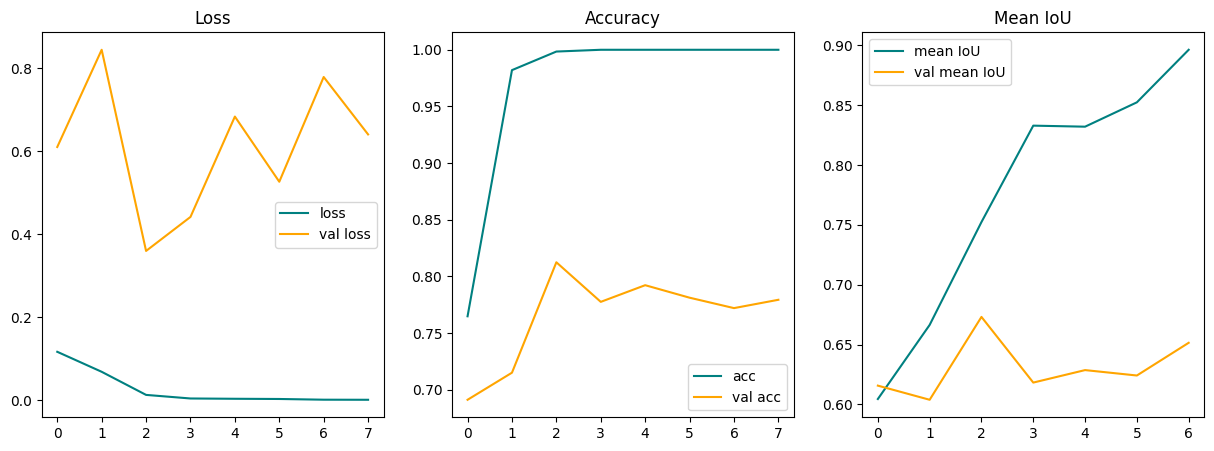

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))

ax[0].plot(hist.history['total loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['accuracy'], color='teal', label='acc')
ax[1].plot(hist.history['val_accuracy'], color='orange', label='val acc')
ax[1].title.set_text('Accuracy')
ax[1].legend()

ax[2].plot(meanlist, color='teal', label='mean IoU')
ax[2].plot(valmeanlist, color='orange', label='val mean IoU')
ax[2].title.set_text('Mean IoU')
ax[2].legend()

plt.show()

***
### Evaluate the model

In [ ]:
from sklearn import metrics
import seaborn as sns

In [ ]:
results = model.evaluate(test)

1/1 [==============================] - 33s 33s/step - total loss: 0.7440 - accuracy: 0.7131 - mean iou: 0.6592 - scene accuracy: 0.8523


In [ ]:
print("test accuracy:", results[0])
print("test mean IoU:", results[1].mean())
print("scene accuracy:", results[2])

test accuracy: 0.7130681872367859
test mean IoU: 0.6591803
scene accuracy: 0.8522727489471436


In [ ]:
testimages, testtruelabels = test.as_numpy_iterator().next()

In [ ]:
pred=model.predict(testimages)

In [ ]:
cm = metrics.confusion_matrix(np.argmax(testtruelabels[0], axis=1), np.argmax(pred[0], axis=1))

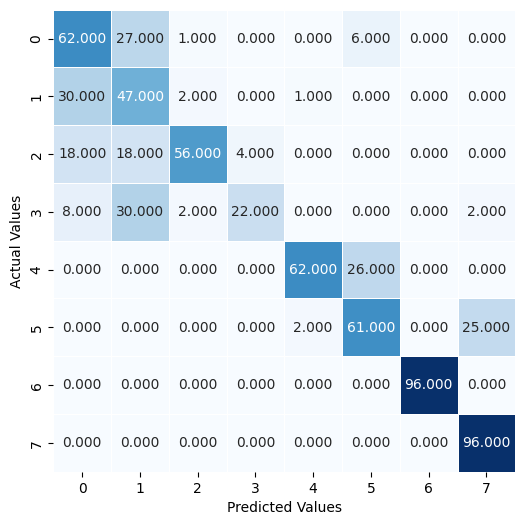

In [ ]:
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='0.3f', linewidth=0.5, square=True, cbar=False, cmap='Blues')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
# print classification metrics results 
print(metrics.classification_report(np.argmax(testtruelabels[0], axis=1), np.argmax(pred[0], axis=1)))

In [ ]:
test_sample = test.as_numpy_iterator().next()

In [ ]:
pred = model.predict(test_sample[0])

In [ ]:
# function to display class and bbox predictions made by trained model
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = pred[1][idx]
    
    img=cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [150,150]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [150,150]).astype(int)), 
                            (255,0,0), 2)
    
    if np.argmax(pred[0][idx]) == 0:
        img = cv2.putText(img, 'football', (tuple(np.multiply(sample_coords[:2], [150,150]).astype(int))[0],
                                          tuple(np.multiply(sample_coords[:2], [150,150]).astype(int))[1]-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)
        
    elif np.argmax(pred[0][idx]) == 1:
        img = cv2.putText(img, 'umbrella', (tuple(np.multiply(sample_coords[:2], [150,150]).astype(int))[0],
                                          tuple(np.multiply(sample_coords[:2], [150,150]).astype(int))[1]-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)
        
    elif np.argmax(pred[0][idx]) == 2:
        img = cv2.putText(img, 'sandcastle', (tuple(np.multiply(sample_coords[:2], [150,150]).astype(int))[0],
                                          tuple(np.multiply(sample_coords[:2], [150,150]).astype(int))[1]-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)
        
    elif np.argmax(pred[0][idx]) == 3:
        img = cv2.putText(img, 'car', (tuple(np.multiply(sample_coords[:2], [150,150]).astype(int))[0],
                                          tuple(np.multiply(sample_coords[:2], [150,150]).astype(int))[1]-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)
        
    elif np.argmax(pred[0][idx]) == 4:
        img = cv2.putText(img, 'airplane', (tuple(np.multiply(sample_coords[:2], [150,150]).astype(int))[0],
                                          tuple(np.multiply(sample_coords[:2], [150,150]).astype(int))[1]-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)
        
    elif np.argmax(pred[0][idx]) == 5:
        img = cv2.putText(img, 'bird', (tuple(np.multiply(sample_coords[:2], [150,150]).astype(int))[0],
                                          tuple(np.multiply(sample_coords[:2], [150,150]).astype(int))[1]-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)
        
    elif np.argmax(pred[0][idx]) == 6:
        img = cv2.putText(img, 'moon', (tuple(np.multiply(sample_coords[:2], [150,150]).astype(int))[0],
                                          tuple(np.multiply(sample_coords[:2], [150,150]).astype(int))[1]-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)
        
    elif np.argmax(pred[0][idx]) == 7:
        img = cv2.putText(img, 'apple', (tuple(np.multiply(sample_coords[:2], [150,150]).astype(int))[0],
                                          tuple(np.multiply(sample_coords[:2], [150,150]).astype(int))[1]-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)

    ax[idx].imshow(img)